In [2]:
import tensorflow as tf
tf.enable_eager_execution()
import numpy as np
import pandas as pd
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [3]:
apple = pd.read_csv('apple.csv', parse_dates=True, index_col=0)

In [4]:
print(apple.tail())

                  High         Low        Open       Close      Volume  \
Date                                                                     
2019-12-12  272.559998  267.320007  267.779999  271.459991  34327600.0   
2019-12-13  275.299988  270.929993  271.459991  275.149994  33396900.0   
2019-12-16  280.790009  276.980011  277.000000  279.859985  32046500.0   
2019-12-17  281.769989  278.799988  279.570007  280.410004  28539600.0   
2019-12-18  281.899994  279.119995  279.799988  279.739990  29007100.0   

             Adj Close  
Date                    
2019-12-12  271.459991  
2019-12-13  275.149994  
2019-12-16  279.859985  
2019-12-17  280.410004  
2019-12-18  279.739990  


In [5]:
apple.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5023 entries, 2000-01-03 to 2019-12-18
Data columns (total 6 columns):
High         5023 non-null float64
Low          5023 non-null float64
Open         5023 non-null float64
Close        5023 non-null float64
Volume       5023 non-null float64
Adj Close    5023 non-null float64
dtypes: float64(6)
memory usage: 274.7 KB


In [6]:
features = apple.loc[:, ['Adj Close']]

In [7]:
features.head()

,Adj Close
Date,
2000-01-03,3.478462
2000-01-04,3.185191
2000-01-05,3.231803
2000-01-06,2.952128
2000-01-07,3.091966


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000023A75F0B988>],
      dtype=object)

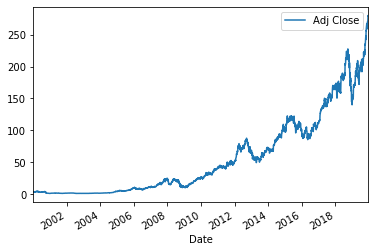

In [8]:
features.plot(subplots=True)

In [9]:
#returns a window of time for the model to train on.
#The history_size is the size of the window
#target_size is how far into the future that model needs to predict
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []
    
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
    
    for i in range(start_index, end_index):
        indicies = range(i-history_size, i)
        # Reshape date from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indicies], (history_size, 1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)

In [10]:
features = features.values

In [11]:
#scalling data
train_split = 3522

uni_train_mean = features[:train_split].mean()
uni_train_std = features[:train_split].std()

features = (features-uni_train_mean)/uni_train_std

In [12]:
#train on the last 500 days of pricing data
univariate_past_history = 500
#the target is the next days adjclose price
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(features, 0, train_split,
                                           univariate_past_history,
                                           univariate_future_target)

x_val_uni, y_val_uni = univariate_data(features, train_split, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [13]:
print('Single window of past history')
print(x_train_uni[0])
print('\n Target price to predict')
print(y_train_uni[0])

Single window of past history
[[-0.7382088 ]
 [-0.75105503]
 [-0.74901326]
 [-0.76126391]
 [-0.75513858]
 [-0.75752066]
 [-0.7643266 ]
 [-0.77189821]
 [-0.75888183]
 [-0.75386247]
 [-0.74909835]
 [-0.74552522]
 [-0.73608199]
 [-0.7390596 ]
 [-0.74595059]
 [-0.73778347]
 [-0.74059089]
 [-0.74084612]
 [-0.75224607]
 [-0.74935354]
 [-0.75411772]
 [-0.75607438]
 [-0.74994905]
 [-0.74356849]
 [-0.73531632]
 [-0.73421032]
 [-0.73727304]
 [-0.73608199]
 [-0.74254761]
 [-0.73293422]
 [-0.72859546]
 [-0.73523121]
 [-0.73421032]
 [-0.73914462]
 [-0.7356566 ]
 [-0.73233872]
 [-0.73376368]
 [-0.74033566]
 [-0.73642229]
 [-0.73455065]
 [-0.71319702]
 [-0.72451187]
 [-0.7163448 ]
 [-0.71949255]
 [-0.72332086]
 [-0.72451187]
 [-0.7241716 ]
 [-0.71940748]
 [-0.72544774]
 [-0.73506107]
 [-0.73233872]
 [-0.72510742]
 [-0.72042834]
 [-0.72315068]
 [-0.70690158]
 [-0.69431061]
 [-0.69822404]
 [-0.70179713]
 [-0.70060609]
 [-0.7012016 ]
 [-0.70554037]
 [-0.71940748]
 [-0.70571058]
 [-0.70911351]
 [-0.71728

In [14]:
#I googled all of this. Just a cool way to see how well your model is performing.
def create_time_steps(length):
    return list(range(-length, 0))

def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

def baseline(history):
    return np.mean(history)

<module 'matplotlib.pyplot' from 'c:\\users\\harris butler\\appdata\\local\\programs\\python\\python37\\lib\\site-packages\\matplotlib\\pyplot.py'>

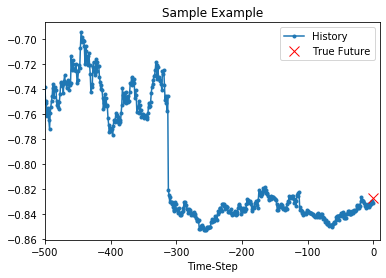

In [15]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

<module 'matplotlib.pyplot' from 'c:\\users\\harris butler\\appdata\\local\\programs\\python\\python37\\lib\\site-packages\\matplotlib\\pyplot.py'>

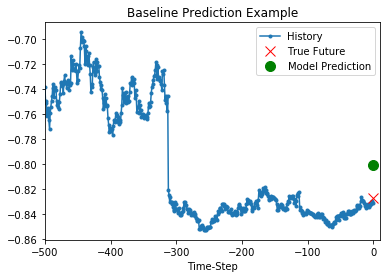

In [16]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

In [17]:
#TensorFlow 
batch_size = 256
buffer_size = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(batch_size).repeat()

In [18]:
#Keras
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [19]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(256, 1)


In [20]:
evaluation_interval = 200
epochs = 10

simple_lstm_model.fit(train_univariate, epochs=epochs,
                     steps_per_epoch=evaluation_interval,
                     validation_data=val_univariate, validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
200/200 [==============================] - 111s 554ms/step - loss: 0.4842 - val_loss: 3.7839
Epoch 2/10
200/200 [==============================] - 96s 481ms/step - loss: 0.0333 - val_loss: 3.3406
Epoch 3/10
200/200 [==============================] - 95s 477ms/step - loss: 0.0274 - val_loss: 3.1688
Epoch 4/10
200/200 [==============================] - 95s 473ms/step - loss: 0.0253 - val_loss: 3.0565
Epoch 5/10
200/200 [==============================] - 95s 474ms/step - loss: 0.0237 - val_loss: 2.9736
Epoch 6/10
200/200 [==============================] - 95s 476ms/step - loss: 0.0225 - val_loss: 2.9055
Epoch 7/10
200/200 [==============================] - 95s 476ms/step - loss: 0.0216 - val_loss: 2.8509
Epoch 8/10
200/200 [==============================] - 98s 492ms/step - loss: 0.0208 - val_loss: 2.8021
Epoch 9/10
200/200 [==================

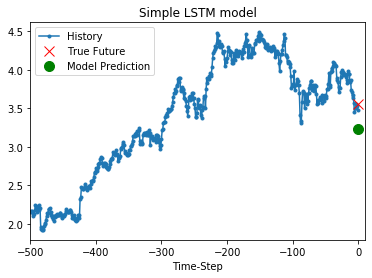

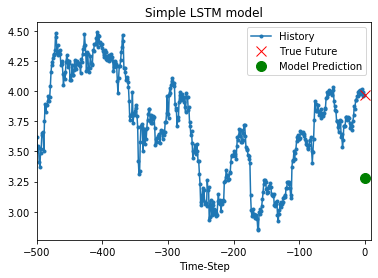

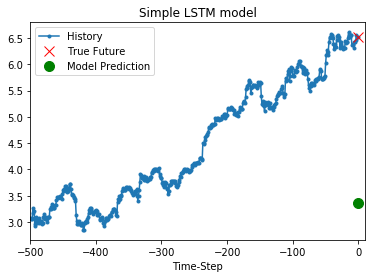

In [21]:
for x, y in val_univariate.take(3):
    plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
    plot.show()